In [39]:
import pandas as pd

# 读取原始CSV文件
data = pd.read_csv("data/image_features.csv")

# 根据文件路径添加标签
data['Label'] = data['Filepath'].apply(lambda x: 1 if 'chop_fire' in x else 0)

# 保存新的CSV文件
data.to_csv("data/image_features_with_labels.csv", index=False)

# 查看前几行数据
data.head()

,Filepath,Width,Height,BandCount,Band1_Min,Band1_Max,Band1_Mean,Band1_StdDev,Band1_BlockMean,Band1_BandSumVariance,...,Band5_StdDev,Band5_BlockMean,Band5_BandSumVariance,Band6_Min,Band6_Max,Band6_Mean,Band6_StdDev,Band6_BlockMean,Band6_BandSumVariance,Label
0,./sentinel/dataset/chop_fire/tile_0_1_2.tif,512,512,6,0.0961,0.2134,0.126994,0.014676,0.126994,25.732317,...,0.038278,0.189229,96.724091,0.0219,0.3376,0.147348,0.057191,0.147348,359.943019,1
1,./sentinel/dataset/chop_fire/tile_0_1_4.tif,512,512,6,0.0000,0.0993,0.023206,0.016182,0.023206,6.253759,...,0.052030,0.269053,14.423780,0.0038,0.4330,0.108075,0.069847,0.108075,291.983138,1
2,./sentinel/dataset/chop_fire/tile_3_1_1.tif,512,512,6,0.1294,0.3138,0.203789,0.038419,0.203789,279.988690,...,0.034659,0.207626,36.311132,0.0142,0.2447,0.065012,0.032640,0.065012,27.397936,1
3,./sentinel/dataset/chop_fire/tile_2_1_4.tif,512,512,6,0.0198,0.4991,0.122030,0.095361,0.122030,2074.143423,...,0.070711,0.253180,179.433437,0.0080,1.5110,0.201812,0.192319,0.201812,1292.319162,1
4,./sentinel/dataset/chop_fire/tile_0_1_1.tif,512,512,6,0.1395,0.1950,0.173387,0.011239,0.173387,11.573026,...,0.038799,0.213506,27.206457,0.0170,0.2835,0.066739,0.033777,0.066739,18.381171,1


In [40]:
data.shape

(78, 41)

In [41]:
# 打乱标签为 1 的数据
data_fire = data[data['Label'] == 1]
data_fire_shuffled = data_fire.sample(frac=1, random_state=42)  # 打乱所有行，frac=1表示100%行
data_fire_shuffled[['Band1_Mean', 'Band2_Mean', 'Band3_Mean', 'Band4_Mean', 'Band5_Mean', 'Band6_Mean']].to_csv("data/fire.csv", index=False)

# 打乱标签为 0 的数据
data_no_fire = data[data['Label'] == 0]
data_no_fire_shuffled = data_no_fire.sample(frac=1, random_state=42)  # 打乱所有行
data_no_fire_shuffled[['Band1_Mean', 'Band2_Mean', 'Band3_Mean', 'Band4_Mean', 'Band5_Mean', 'Band6_Mean']].to_csv("data/no_fire.csv", index=False)


In [42]:
# data = data[['Band1_Mean', 'Band2_Mean', 'Band3_Mean', 'Band4_Mean', 'Band5_Mean', 'Band6_Mean','Label']]
data=data.drop(columns=['Filepath'])
# X = data[['Band1_Mean', 'Band2_Mean', 'Band3_Mean', 'Band4_Mean', 'Band5_Mean', 'Band6_Mean']]
X = data.drop(columns=['Label']) 
Y = data['Label']


### 0.2划分测试集做逻辑斯蒂回归(效果极差)

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, Y_train)

# Predict on the test set
Y_pred = log_reg.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.56


/home/mannersg/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


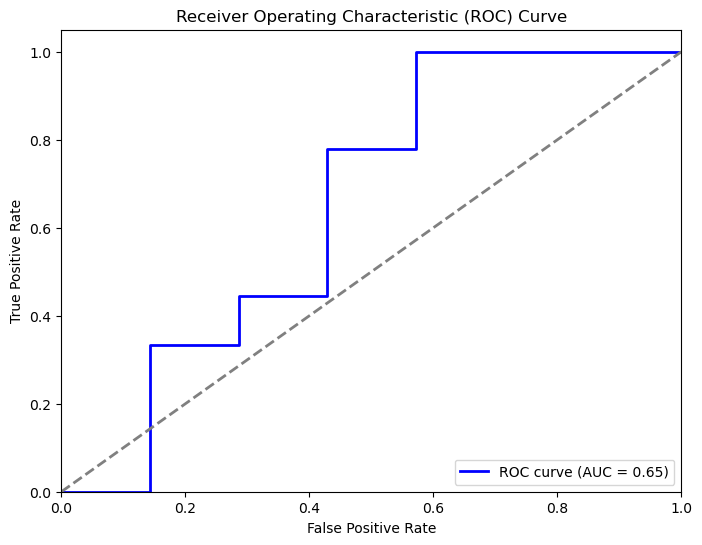

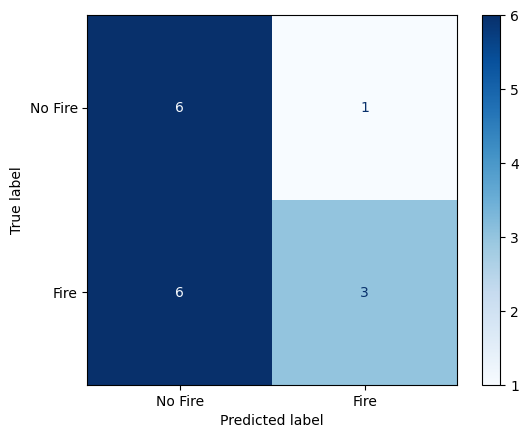

AUC: 0.65
Confusion Matrix:
[[6 1]
 [6 3]]


In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities (for ROC curve)
Y_prob = log_reg.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Generate confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Fire', 'Fire'])
disp.plot(cmap='Blues')
plt.show()

# Print AUC score
print(f"AUC: {roc_auc:.2f}")

# Print confusion matrix
print("Confusion Matrix:")
print(cm)
